Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


You can download and run this notebook locally, or you can run it for free in a cloud environment using Colab or Sagemaker Studio Lab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/model_zoo/TCIA_PROSTATEx_Prostate_MRI_Anatomy_Model.ipynb)

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/Project-MONAI/tutorials/blob/main/model_zoo/TCIA_PROSTATEx_Prostate_MRI_Anatomy_Model.ipynb)

# Summary
This notebook demonstrates downloading the [Prostate mri anatomy](https://github.com/Project-MONAI/model-zoo/releases/download/hosting_storage_v1/prostate_mri_anatomy_v0.3.1.zip) model from MONAI's Model Zoo and applying it to segment a subset of data from the [SPIE-AAPM-NCI PROSTATEx Challenges (PROSTATEx) collection](https://doi.org/10.7937/K9TCIA.2017.MURS5CL10.7937/TCIA.X0H0-1706) on [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/).  The resulting data are then visualized using [itkWidgets].(https://github.com/InsightSoftwareConsortium/itkwidgets)

Features demonstrated include:
* Using a python script to download and load a model from MONAI's Model Zoo into python.
* Downloading and preparing data from TCIA for processing using that model.
* Applying the model to the TCIA data.
* Visually comparing model results with expert segmentation results available on TCIA.

# Background
[MONAI's Model Zoo](https://monai.io/model-zoo.html) provides pre-trained AI deep learning models that can be downloaded and used to process new data or as a starting point for transfer learning.  The [Prostate mri anatomy](https://github.com/Project-MONAI/model-zoo/releases/download/hosting_storage_v1/prostate_mri_anatomy_v0.3.1.zip) model was trained with the UNet architecture and is used for 3D volumetric segmentation of the anatomical prostate zones on T2w MRI images. The segmentation of the anatomical regions is formulated as a voxel-wise classification. Each voxel is classified as either central gland (1), peripheral zone (2), or background (0). The model is optimized using a gradient descent method that minimizes the focal soft-dice loss between the predicted mask and the actual segmentation. The model was trained in the prostate158 training data, which is available at https://doi.org/10.5281/zenodo.6481141. Only T2w images were used for this task.

[The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute that addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers. Its rich collection of clinical data and annotations is particularly powerful as a community resource when it is paired with interactive code systems, such as Jupyter systems.

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) allows researchers to visualize images, point sets, and 3D geometry in Jupyter systems (Jupyer Notebooks, JupyterLab, AWS SageMaker, and Google Colab). Despite its name, itkWidgets does not require the use of ITK. It can directly visualize numpy arrays, torch tensors, DASK arrays, VTK polydata, and a multitude of other python data structures.

# Outline

1. Setup
2. Download data from TCIA
3. Prepare the data with ITK
4. Setup itkWidgets
5. MONAI Zoo Basics
6. MONAI Model Inference
7. Visualizing and Comparing Model and Expert Results

# 1. Setup

These are the initial steps for running notebooks within various Jupyter environments.

## Setup environment

## Setup imports

### Setup the im-joy-jupyter-extension for itkWidgets
On many systems you must manually install the imjoy-jupyter-extension for itkWidgets! If you do not see a blue 'ImJoy' icon on the menu bar in this notebook:

* Google CoLab: The following does not apply to Google CoLab - it will not show an ImJoy and all should work without modification.
* Enable Extensions: Many Jupyter Lab systems disable jupyter extensions by default, and they must be enabled for this notebook to work. Typically this is accomplished using the Jupyter interface to select the extension manager (left-hand side, icon that looks like a piece of a puzzle) and select the Enable button if it appears.
* Install imjoy extension: In the extension manager, search for 'imjoy' and install the 'imjoy-jupyter-extension'. The installation can take several minutes. It may also prompt you to rebuild, save, and reload your jupyter environment as part of this process. In the end, you should see a blue 'ImJoy' icon on the left side of the menu bar in this notebook.

In [2]:
import sys
print(sys.executable)
print(sys.version)

/home/esl/anaconda3/envs/monai/bin/python
3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]


In [3]:
%pip install --upgrade pip
%pip install "monai[nibabel,itk,tqdm,pandas,skimage]" "numpy<2"
%pip install opencv-python-headless "numpy<2"
%pip install pydicom
%pip install --upgrade "tcia_utils==3.2.1"
%pip install --upgrade "itkwidgets[all]>=1.0a55" "zarr<3"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
os.environ["MONAI_USE_CUPY"] = "0"

In [5]:
%pip uninstall -y cupy cupy-cuda11x cupy-cuda12x

Found existing installation: cupy-cuda12x 13.6.0
Uninstalling cupy-cuda12x-13.6.0:
  Successfully uninstalled cupy-cuda12x-13.6.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
try:
    import cupy
    print("CuPy 還活著... (失敗)")
except ImportError:
    print("CuPy 已被消滅，MONAI 現在安全了。 (成功)")

CuPy 已被消滅，MONAI 現在安全了。 (成功)


In [7]:
# Install itk for DICOM I/O and for reading DICOM into an itkImage
#   that manages all DICOM field values, include acquistion details
#   such as voxel image, image orientation, and image directions,
#   which are critical to image processing and display.

# Upgrade pip, just in case.
%pip install --upgrade -q pip

# installations required for monai
%pip install -q "monai[nibabel,itk,tqdm,pandas,skimage]"
%pip install -q opencv-python-headless

# install pydicom to read dicom data
%pip install pydicom

# Install tcia_utils to download the datasets.
%pip install --upgrade -q tcia_utils==3.2.1


# This is the installation required for itkWidgets.
# Setup for the imjoy-jupyter-extension for itkWidgets varies in Google Colab,
# Jupyter Notebook and Jupyter Lab. See https://github.com/InsightSoftwareConsortium/itkwidgets/tree/main
# for more details, but the following should install what you need for all 3 environments.
# Afterwards, the ImJoy icon should appear in the top icon bar of Jupyter
# Notebook and Jupyter Lab.  No icon will appear in Google Colab.
%pip install --upgrade -q "itkwidgets[all]>=1.0a55" "zarr<3"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import glob
import os

# Numpy for numpy.arrays
import numpy as np

# Include ITK and pydicom for DICOM reading.
import itk
import pydicom

# for downloading data from TCIA
from tcia_utils import nbia

# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# imports for monai
import torch
from monai.data import decollate_batch
from monai.bundle import ConfigParser, download

from monai.config import print_config

print_config()

MONAI version: 1.5.1
Numpy version: 1.26.4
Pytorch version: 2.8.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9c6d819f97e37f36c72f3bdfad676b455bd2fa0d
MONAI __file__: /home/<username>/anaconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.5
Nibabel version: 5.3.2
scikit-image version: 0.22.0
scipy version: 1.13.1
Pillow version: 11.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.23.0+cu128
tqdm version: 4.67.1
lmdb version: 1.7.5
psutil version: 7.1.3
pandas version: 2.3.3
einops version: 0.8.1
transformers version: 4.57.3
mlflow version: 3.1.4
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [9]:
# If running on SageMaker or Studio Lab, install essential packages and extensions.
if "studio-lab-user" in os.getcwd():
    print("Upgrading dependencies")
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs

# 2. Download the data from TCIA

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and viewing [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) of datasets on TCIA are the easiest ways to become familiar with what is available. These pages will help you quickly identify datasets of interest, find valuable, supporting data that are not available via TCIA's APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer the most common questions you might have about the datasets.  In this tutorial we'll be working with the [SPIE-AAPM-NCI PROSTATEx Challenges (PROSTATEx) collection](https://doi.org/10.7937/K9TCIA.2017.MURS5CL), but if you browse the previously mentioned links you will find that TCIA has many other prostate datasets which could be used with the [Prostate mri anatomy](https://github.com/Project-MONAI/model-zoo/releases/download/hosting_storage_v1/prostate_mri_anatomy_v0.3.1.zip) model. 

We will utilize the [tcia_utils](https://pypi.org/project/tcia-utils/) package to simplify downloading the data from TCIA.  If you are new to accessing TCIA via notebooks, you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks. 

In [10]:
# Download a "Shared Cart" containing 6 scans from PROSTATEx
#    that has been previously created via the TCIA website
#    (https://nbia.cancerimagingarchive.net).
cart_name = "nbia-17571668146714049"

# retrieve cart metadata
cart_data = nbia.getSharedCart(cart_name)

# download the series_uids list and return dataframe of metadata
df = nbia.downloadSeries(cart_data, format="df")

# display dataframe
# display(df)

# 3. Prepare the data with itk


In [11]:
dicom_data_dir = "tciaDownload"

# The series_uid defines their directory where the MR data was stored on disk.
mr_series_uid = df.at[df.Modality.eq("MR").idxmax(), "SeriesInstanceUID"]
mr_dir = os.path.join(dicom_data_dir, mr_series_uid)

# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI).
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html.
mr_image = itk.imread(mr_dir, itk.F)

In [12]:
# The series_uid defines where the SEG was stored on disk.  It is stored in a single file.
seg_series_uid = df.at[df.Modality.eq("SEG").idxmax(), "SeriesInstanceUID"]
seg_dir = os.path.join(dicom_data_dir, seg_series_uid)
seg_file = glob.glob(os.path.join(seg_dir, "*.dcm"))[0]

# Read the DICOM SEG object using pydicom.
seg_dcm = pydicom.dcmread(seg_file, force=True)

# Define the DICOM SEG SOP Class UID
SEG_UID = "1.2.840.10008.5.1.4.1.1.66.4"

# Extract segment metadata and create frame mapping
segment_metadata = {}
frame_mapping = {}
if seg_dcm.SOPClassUID == SEG_UID:
    print("Detected DICOM SEG file. Loading...")
    stacked_mask_np = seg_dcm.pixel_array
    for seg_item in seg_dcm.SegmentSequence:
        seg_num, seg_label = seg_item.SegmentNumber, seg_item.SegmentLabel
        segment_metadata[seg_num] = seg_label
    for i, frame_item in enumerate(seg_dcm.PerFrameFunctionalGroupsSequence):
        seg_id_item = frame_item.SegmentIdentificationSequence[0]
        segment_number = seg_id_item.ReferencedSegmentNumber
        if segment_number not in frame_mapping:
            frame_mapping[segment_number] = []
        frame_mapping[segment_number].append(i)

    # Create a zero-filled numpy array with the same shape as the MR image and integer type
    mr_image_shape = itk.GetArrayViewFromImage(mr_image).shape
    label_map_np = np.zeros(mr_image_shape, dtype=np.uint8)  # Use uint8 for labels

    # Reconstruct the label map from stacked masks
    for segment_number, frame_indices in frame_mapping.items():
        # Ensure frame_indices are within the bounds of stacked_mask_np
        valid_frame_indices = [idx for idx in frame_indices if idx < stacked_mask_np.shape[0]]
        if valid_frame_indices:
            segment_mask = stacked_mask_np[valid_frame_indices] > 0
            # Assuming the mask shape is compatible with assigning to label_map_np slice
            # Need to handle potential shape mismatches or different image orientations/spacings
            # For simplicity here, assuming direct slice assignment is possible.
            # A more robust approach would involve resampling the segmentation to the MR image grid.
            label_map_np[segment_mask] = segment_number
    print("Successfully created label map from DICOM SEG.")

    # Convert the numpy array into an itk image, with correct voxel origin, spacing, and directions in physical space.
    # Use an appropriate integer data type for the ITK image.
    seg_image = itk.GetImageFromArray(label_map_np, is_vector=False)
    seg_image.CopyInformation(mr_image)

else:
    print(f"File is not a DICOM SEG file (SOP Class UID: {seg_dcm.SOPClassUID}). Skipping segmentation loading.")
    # Create an empty ITK image if it's not a SEG file
    seg_image = itk.Image[itk.UC, mr_image.GetImageDimension()].New()
    seg_image.CopyInformation(mr_image)

# Display segment metadata if available
if segment_metadata:
    print("\nSegment Metadata:")
    for seg_num, seg_label in segment_metadata.items():
        print(f"  Segment Number {seg_num}: {seg_label}")

Detected DICOM SEG file. Loading...
Successfully created label map from DICOM SEG.

Segment Metadata:
  Segment Number 1: Peripheral zone of prostate
  Segment Number 2: Transition zone of prostate
  Segment Number 3: Prostatic Urethra
  Segment Number 4: Anterior fibromuscular stroma of prostate


# 4. MONAI Zoo Basics

In [13]:
model_name = "prostate_mri_anatomy"
model_version = "0.3.1"
zoo_dir = os.path.abspath("./models")

download(name=model_name, version=model_version, bundle_dir=zoo_dir)

2025-11-30 14:39:41,806 - INFO - --- input summary of monai.bundle.scripts.download ---
2025-11-30 14:39:41,807 - INFO - > name: 'prostate_mri_anatomy'
2025-11-30 14:39:41,807 - INFO - > version: '0.3.1'
2025-11-30 14:39:41,807 - INFO - > bundle_dir: '/home/esl/monai/tutorials/model_zoo/models'
2025-11-30 14:39:41,808 - INFO - > source: 'monaihosting'
2025-11-30 14:39:41,808 - INFO - > remove_prefix: 'monai_'
2025-11-30 14:39:41,808 - INFO - > progress: True
2025-11-30 14:39:41,808 - INFO - ---


2025-11-30 14:39:42,124 - INFO - Expected md5 is None, skip md5 check for file /home/esl/monai/tutorials/model_zoo/models/prostate_mri_anatomy_v0.3.1.zip.
2025-11-30 14:39:42,125 - INFO - File exists: /home/esl/monai/tutorials/model_zoo/models/prostate_mri_anatomy_v0.3.1.zip, skipped downloading.
2025-11-30 14:39:42,127 - INFO - Writing into directory: /home/esl/monai/tutorials/model_zoo/models.


In [14]:
# This model includes scripts that must be run on new data.
#    We could import those scripts into this python notebook, but they
#    bring in additional dependencies.   Instead, we provide the following
#    more compact and compatible implementation.  Otherwise, you can
#    include the model's script directory by uncommenting these lines and
#    installing their dependencies and doing appropriate data conversions.
# scripts_dir = os.path.join(zoo_dir, model_name, "scripts")
# sys.path.insert(1, scripts_dir)


# Compact alternative implementation of this model's specific cropping step.
#   Ideally this would have been accomplished using MONAI's transforms
#   for data pre-processing / augmentation instead of using a separate
#   function.
def prostate_crop(img):
    boundary = [int(crop_size * 0.2) for crop_size in img.GetLargestPossibleRegion().GetSize()]
    new_image = itk.CropImageFilter(Input=img, BoundaryCropSize=boundary)
    return new_image


mr_image_prep = prostate_crop(mr_image)
seg_image_prep = prostate_crop(seg_image)

# Running a MONAI model on new data requires that data to be saved on
#   local disk.
itk.imwrite(mr_image_prep, mr_dir + ".nii.gz")
itk.imwrite(seg_image_prep, seg_dir + ".nii.gz")

In [15]:
# The model's config file dynamically generates the functions needed to process new data.

# Define our local system and filesystem.
output_dir = os.path.abspath("./monai_results")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parse the variables in the config file.
model_config_file = os.path.join(zoo_dir, model_name, "configs", "inference.json")
model_config = ConfigParser()
model_config.read_config(model_config_file)

# Update the confir variables to match our filesystem.
model_config["bundle_root"] = zoo_dir
model_config["output_dir"] = output_dir

# Identify which version of the model we want to load (each version is a
#    "checkpoint").  For most models, the "best" checkpoint is called "model.pt"
#    and it is stored in the models subdir.
checkpoint = os.path.join(zoo_dir, model_name, "models", "model.pt")

# Ask the config file to generate the functions needed to process new data.
#    These functions are adapted to our system by the config variables we
#    modified above.  The order of first defining variables and then creating the
#    functions is critical.
preprocessing = model_config.get_parsed_content("preprocessing")

model = model_config.get_parsed_content("network").to(device)

inferer = model_config.get_parsed_content("inferer")

postprocessing = model_config.get_parsed_content("postprocessing")

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


In [16]:
# Point the dataloader to the downloaded and converted TCIA data.
datalist = [mr_dir + ".nii.gz"]
model_config["datalist"] = datalist
dataloader = model_config.get_parsed_content("dataloader")

In [17]:
%pip install imjoy-jupyter-extension

Note: you may need to restart the kernel to use updated packages.


# 5. Visualize the data with itkWidgets

[itkWidgets documentation](https://itkwidgets.readthedocs.io/en/latest/?badge=latest) provides a summary and illustrations of itkWidgets for a wide variety of scientific data visualization use cases.


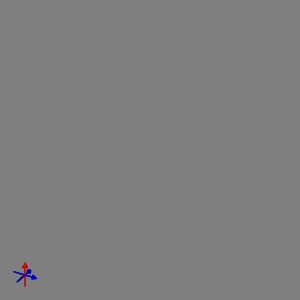
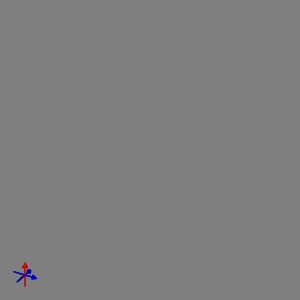

<IPython.core.display.Javascript object>

In [18]:
view(image=mr_image_prep, label_image=seg_image_prep)

# 6. MONAI Model Inference

In [19]:
model.load_state_dict(torch.load(checkpoint, map_location=device, weights_only=True))
model.eval()
results = []
with torch.no_grad():
    for d in dataloader:
        images = d["image"].to(device)
        d["pred"] = inferer(images, network=model)
        results.append([postprocessing(i) for i in decollate_batch(d)])

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


2025-11-30 14:39:51,873 INFO image_writer.py:197 - writing: /home/esl/monai/tutorials/model_zoo/monai_results/1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270520544417996275680/1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270520544417996275680_trans.nii.gz


# 7. Visualizing and Comparing Model and Expert Results

In [20]:
# Read the result image that was written into the output_dir.
result_image = itk.imread(
    os.path.join(output_dir, os.path.split(mr_dir)[1], os.path.split(mr_dir)[1] + "_trans.nii.gz")
)

In [21]:
# Various manipulations were done to the input image before it is fed to the model
#    for inference.   As a result, the result image may not be in the same
#    spacing, orientation, etc as the original input data.  So, we resample the results
#    image to match the physical properties of the original input data.
interpolator = itk.NearestNeighborInterpolateImageFunction.New(seg_image.astype(result_image.dtype))
result_image_resampled = itk.resample_image_filter(
    Input=result_image, Interpolator=interpolator, reference_image=seg_image_prep, use_reference_image=True
)


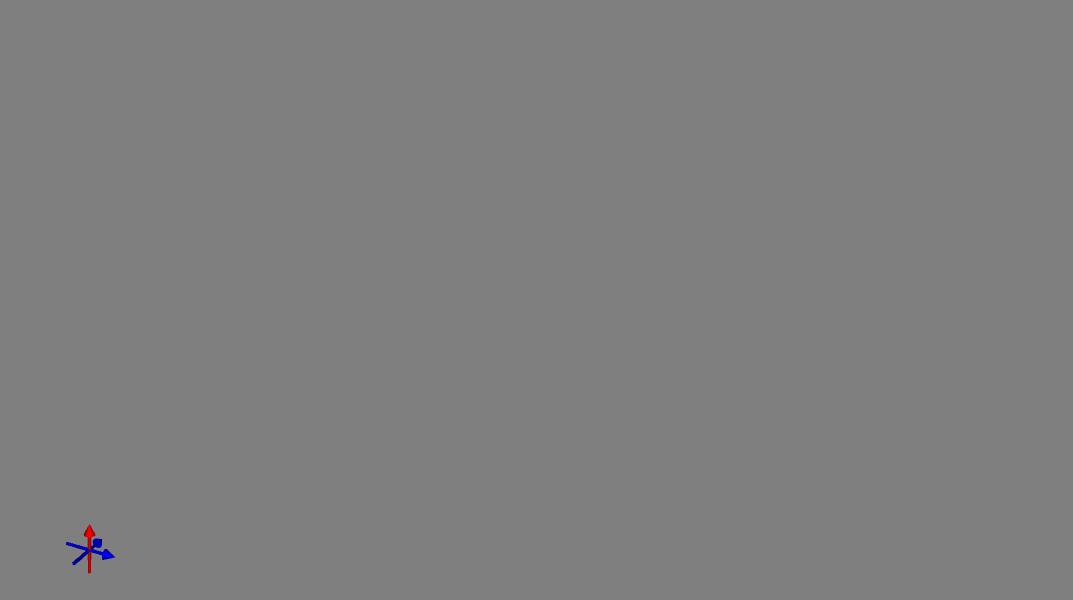
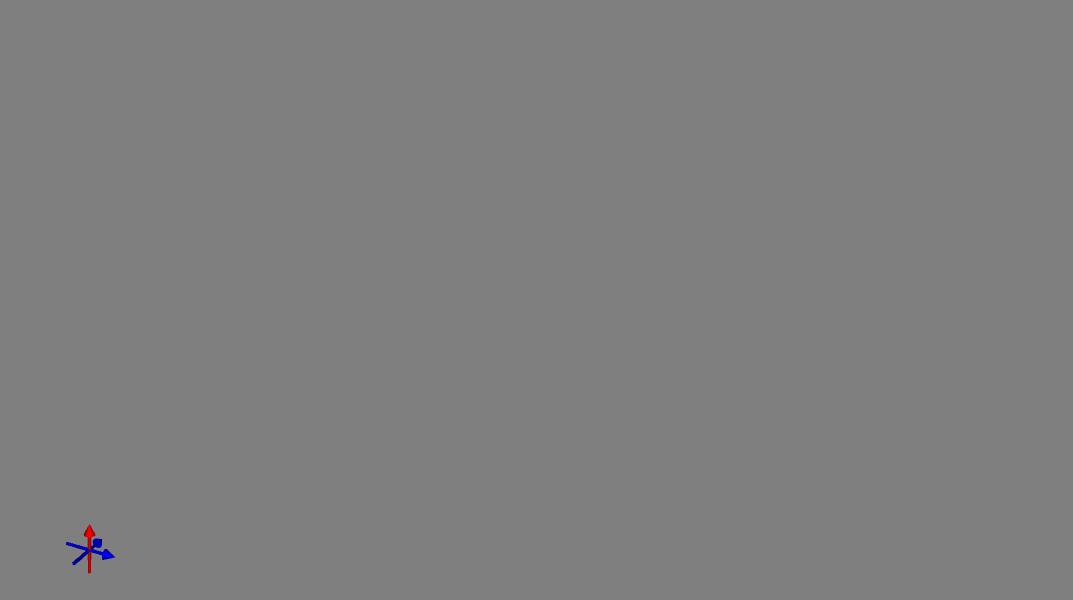

<IPython.core.display.Javascript object>

In [22]:
# View the image with results overlaid in an interactive 2D slice viewer.

# Get the unique label values in the model result image (excluding background 0)
unique_result_labels = sorted(
    [label for label in np.unique(itk.GetArrayViewFromImage(result_image_resampled)) if label != 0]
)

# Create lists for itkWidgets for the model results
# The model output labels are likely 1, 2, 3 for Central Gland, Peripheral Zone, Background
# Based on the background info, the model labels are: 0: background, 1: central gland, 2: peripheral zone.
# We need to map these model labels to the original segment names.
# Assuming model output labels 1->Central Gland, 2->Peripheral Zone based on background info.
# The expert labels are 1: Peripheral zone, 2: Transition zone, 3: Prostatic Urethra, 4: Anterior fibromuscular stroma.
# The comparison image labels are 1, 2, 3.

# Let's create names for the model output labels based on the model's documentation/description.
# Assuming model labels 1, 2 correspond to Central Gland and Peripheral Zone respectively.
model_label_names = ["Background", "Central Gland", "Peripheral Zone"]
model_label_weights = [0.0, 1.0, 1.0]  # Weight 0 for background, 1 for others


viewer_b = view(
    image=mr_image_prep,
    label_image=result_image_resampled,
    label_image_names=model_label_names,
    label_image_weights=model_label_weights,
)

In [23]:
viewer_b.set_image_color_map("Grayscale")
viewer_b.set_label_image_blend(0.5)
viewer_b.set_image_color_range([100, 500])
viewer_b.set_view_mode("ZPlane")
viewer_b.set_ui_collapsed(False)


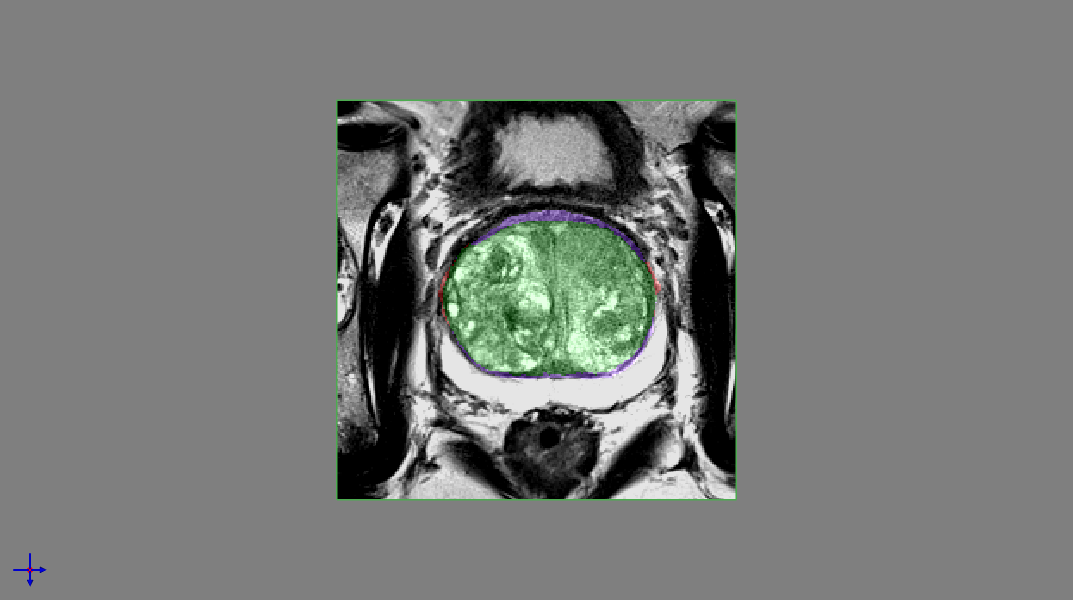
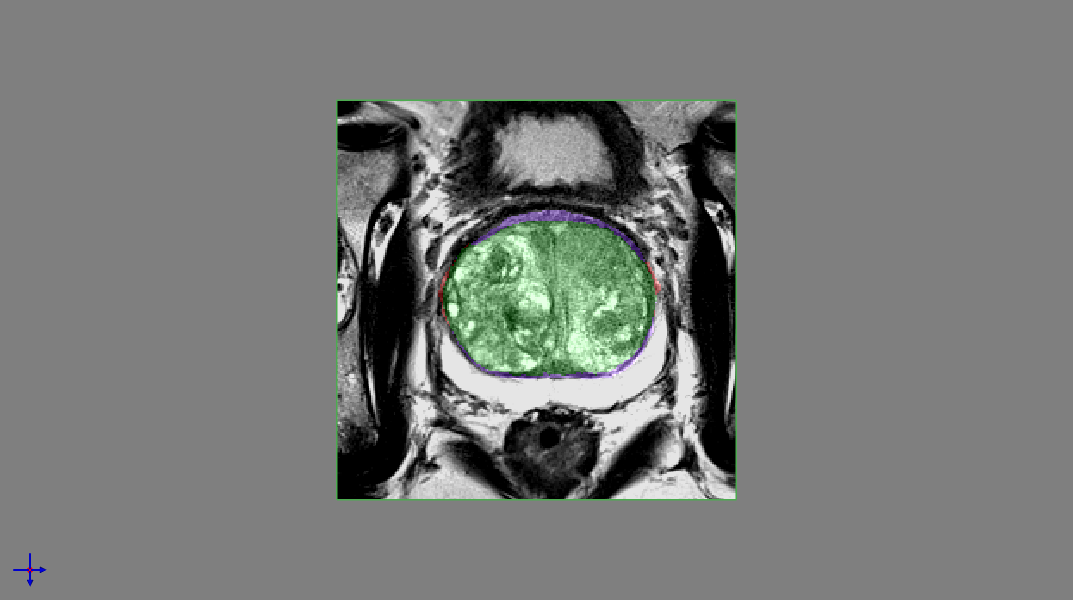

<IPython.core.display.Javascript object>

In [24]:
result_array = itk.GetArrayViewFromImage(result_image_resampled)
expert_array = itk.GetArrayViewFromImage(seg_image_prep)

# Note that the data in the ProstateX repo uses different labels than the data used to
#    build the model.  For example, the prostate is label 1 in the model and label 2
#    in the ProstateX data.
# The following creates a label image where
#    1 = ideal prostate, but model called non-prostate (red)
#    2 = model called prostate, but ideal called non-prostate (purple)
#    3 = modeal and ideal agreed (green)
compare_model_expert = np.where(result_array != 1, 0, 2) + np.where(expert_array != 2, 0, 1)
compare_image = itk.GetImageFromArray(compare_model_expert.astype(np.float32))
compare_image.CopyInformation(seg_image_prep)

viewer_c = view(image=mr_image_prep, label_image=compare_image)

In [25]:
# Switch to an interactive slice view so that labels are more easily seen.
viewer_c.set_label_image_blend(0.6)
viewer_c.set_image_color_map("Grayscale")
viewer_c.set_view_mode("ZPlane")
viewer_c.set_image_color_range([100, 500])
viewer_c.set_ui_collapsed(False)

# Acknowledgements

TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

If you leverage this notebook or any TCIA datasets in your work, please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to TCIA citation provided below!

This notebook was created by [Stephen Aylward (Kitware)](https://www.kitware.com/stephen-aylward/), [Justin Kirby (Frederick National Laboratory for Cancer Research)](https://www.linkedin.com/in/justinkirby82/), [Brianna Major (Kitware)](https://www.kitware.com/brianna-major/), and [Matt McCormick (Kitware)](https://www.kitware.com/matt-mccormick/).   The creation of this notebook was funded, in part, by NIBIB and NIGMS R01EB021396,
NIBIB R01EB014955, NCI R01CA220681, and NINDS R42NS086295.

If you have any questions, suggestions, or issues with itkWidgets, please post them on the [itkwidget issue tracker](https://github.com/InsightSoftwareConsortium/itkwidgets/issues) or feel free to email us at kitware@kitware.com.

## Dataset Citation
The data used in this notebook was part of the SPIE-AAPM-NCI PROSTATEx Challenges (PROSTATEx) collection:

Geert Litjens, Oscar Debats, Jelle Barentsz, Nico Karssemeijer, and Henkjan Huisman. "ProstateX Challenge data", The Cancer Imaging Archive (2017). DOI: [10.7937/K9TCIA.2017.MURS5CL](https://doi.org/10.7937/K9TCIA.2017.MURS5CL)

## Publication Citation
The data used in this notebook was part of the SPIE-AAPM-NCI PROSTATEx Challenges (PROSTATEx) collection:

Litjens G, Debats O, Barentsz J, Karssemeijer N, Huisman H. "Computer-aided detection of prostate cancer in MRI", IEEE Transactions on Medical Imaging 2014;33:1083-1092. DOI: [10.1109/TMI.2014.2303821](https://doi.org/10.1109/TMI.2014.2303821)

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7